In [1]:
import os 
from glob import glob 
from PIL import Image
import numpy as np
import lpips
# loss_fn_alex = lpips.LPIPS(net='alex') 
loss_fn_vgg = lpips.LPIPS(net='vgg') 

from skimage.measure import compare_ssim
from skimage.metrics import structural_similarity
def psnr_metric(img_gt, img_pred):
    mse = np.mean((img_pred - img_gt)**2)
    psnr = -10 * np.log(mse) / np.log(10)
    return psnr

import torch 
def get_lpips(net, img_gt, img_pred):
    gt_tensor = torch.from_numpy(img_gt.transpose(2, 0, 1)).float()
    pred_tensor = torch.from_numpy(img_pred.transpose(2, 0, 1)).float()

    # normalize 
    gt_tensor = gt_tensor * 2 - 1
    pred_tensor = pred_tensor * 2 - 1
    d = net(gt_tensor[None, :],  pred_tensor[None, :])
    return d 

def masked_img(img):
    mask = img[:,:,-1] != 0
    H, W, _ = img.shape
    tmp = np.zeros((H, W, 3))
    tmp[mask] = img[mask]
    return tmp


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/server/anaconda3/envs/icon/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/server/anaconda3/envs/icon/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [2]:
import numpy as np
import pickle
import cv2
def load_calib(calib_path):
    calib = np.loadtxt(calib_path, dtype=float)
    extrinsic, intrinsic = calib[:4], calib[4:]
    intrinsic[1, 1] = -intrinsic[1, 1]
    intrinsic[1, 2] = -intrinsic[1, 2]
    return extrinsic, intrinsic
from lib.smplx.body_models import (create)
smplx_model_folder = \
'/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/smpl_related/models'
model_init_params = dict(
		gender='male',
		model_type='smplx',
		model_path=smplx_model_folder,
		create_global_orient=False,
		create_body_pose=False,
		create_betas=False,
		create_left_hand_pose=False,
		create_right_hand_pose=False,
		create_expression=False,
		create_jaw_pose=False,
		create_leye_pose=False,
		create_reye_pose=False,
		create_transl=False,
		num_pca_comps=12) 
smplx_model = create(**model_init_params)

@torch.no_grad()
def load_smpl(smplx_model, smplx_params):
		smplx_input = {}
		for k in smplx_params:
				smplx_input[k] = torch.as_tensor(
						smplx_params[k], dtype=torch.float32)[None, ...]
		# Important! We compute rays in canonical space of smplx.
		# Note that global_orient should not influence the position of root joint.
		smplx_input["global_orient"] = torch.zeros_like(smplx_input["global_orient"])
		smplx_output = smplx_model(
				**smplx_input,
				return_verts=True,
				return_full_pose=True,
				pose2rot=True,
		)
		root_joint = smplx_output.joints[0, 0].detach().cpu().numpy()
		return root_joint, smplx_output

def load_calibration_of_smplx(intrinsic, extrinsic, Th, scale, global_orient, root_joint):
		
	H, W = 512, 512


	Th = np.array(
		[
			[1, 0, 0, Th[0]],
			[0, 1, 0, Th[1]],
			[0, 0, 1, Th[2]],
			[0, 0, 0, 1,]

		]
	)
	scale = np.array(
		[
			[scale, 0, 0, 0],
			[0, scale, 0, 0],
			[0, 0, scale, 0],
			[0, 0, 0, 1,]
		]
	)
	back_root_joint = np.array(
		[
			[1., 0., 0., -root_joint[0]],
			[0., 1., 0., -root_joint[1]],
			[0., 0., 1., -root_joint[2]],
			[0., 0., 0., 1.],

		]
	)
	go_root_joint = np.array(
		[
			[1., 0., 0., root_joint[0]],
			[0., 1., 0., root_joint[1]],
			[0., 0., 1., root_joint[2]],
			[0., 0., 0., 1.],

		]
	)
	global_orient_, _ = cv2.Rodrigues(global_orient)
	global_orient = np.eye(4)
	global_orient[:3, :3] = global_orient_
	smplx2scan = Th @ scale @ go_root_joint @ global_orient @ back_root_joint
	calib = intrinsic @ extrinsic @ smplx2scan
	temp = cv2.decomposeProjectionMatrix(calib[:3])
	K, camera_R, camera_t = temp[0], temp[1], temp[2]
	camera_t = camera_t[:3] / camera_t[3:]
	camera_t = -(camera_R @ camera_t)
	camera_t = camera_t.ravel()

	extrinsic = np.eye(4)
	extrinsic[:3, :3] = camera_R
	extrinsic[:3, 3] = camera_t

	rot_x_180 = np.eye(4)
	rot_x_180[1, 1] = -1.
	rot_x_180[2, 2] = -1.
	extrinsic = rot_x_180 @ extrinsic
	camera_R = extrinsic[:3, :3]
	camera_t = extrinsic[:3, 3]

	to_pixel = np.eye(3)
	to_pixel[0, 0] = W / 2.
	to_pixel[1, 1] = H / 2.
	to_pixel[0, 2] = W / 2.
	to_pixel[1, 2] = H / 2.
	K = to_pixel @ K

	return calib, K, camera_R, camera_t, smplx2scan

def get_rays(H, W, K, R, T):
	rays_o = -np.dot(R.T, T).ravel()

	i, j = np.meshgrid(
		np.arange(W, dtype=np.float32),
		np.arange(H, dtype=np.float32), indexing='xy')

	xy1 = np.stack([i, j, np.ones_like(i)], axis=2)
	pixel_camera = np.dot(xy1, np.linalg.inv(K).T)
	pixel_world = np.dot(pixel_camera - T.ravel(), R)
	rays_d = pixel_world - rays_o[None, None]
	rays_o = np.broadcast_to(rays_o, rays_d.shape)

	return rays_o, rays_d

def get_near_far(bounds, ray_o, ray_d, boffset=(-0.01, 0.01)):
	"""calculate intersections with 3d bounding box"""
	bounds = bounds + np.array([boffset[0], boffset[1]])[:, None]
	nominator = bounds[None] - ray_o[:, None]
	# calculate the step of intersections at six planes of the 3d bounding box
	ray_d[np.abs(ray_d) < 1e-5] = 1e-5
	d_intersect = (nominator / ray_d[:, None]).reshape(-1, 6)
	# calculate the six interections
	p_intersect = d_intersect[..., None] * ray_d[:, None] + ray_o[:, None]
	# calculate the intersections located at the 3d bounding box
	min_x, min_y, min_z, max_x, max_y, max_z = bounds.ravel()
	eps = 1e-6
	p_mask_at_box = (p_intersect[..., 0] >= (min_x - eps)) * \
					(p_intersect[..., 0] <= (max_x + eps)) * \
					(p_intersect[..., 1] >= (min_y - eps)) * \
					(p_intersect[..., 1] <= (max_y + eps)) * \
					(p_intersect[..., 2] >= (min_z - eps)) * \
					(p_intersect[..., 2] <= (max_z + eps))
	# obtain the intersections of rays which intersect exactly twice
	mask_at_box = p_mask_at_box.sum(-1) == 2
	p_intervals = p_intersect[mask_at_box][p_mask_at_box[mask_at_box]].reshape(
		-1, 2, 3)

	# calculate the step of intersections
	ray_o = ray_o[mask_at_box]
	ray_d = ray_d[mask_at_box]
	norm_ray = np.linalg.norm(ray_d, axis=1)
	d0 = np.linalg.norm(p_intervals[:, 0] - ray_o, axis=1) / norm_ray
	d1 = np.linalg.norm(p_intervals[:, 1] - ray_o, axis=1) / norm_ray
	near = np.minimum(d0, d1)
	far = np.maximum(d0, d1)

	return near, far, mask_at_box

def get_mask_at_box(bounds, K, R, T, H, W):
	ray_o, ray_d = get_rays(H, W, K, R, T)

	ray_o = ray_o.reshape(-1, 3).astype(np.float32)
	ray_d = ray_d.reshape(-1, 3).astype(np.float32)
	near, far, mask_at_box = get_near_far(bounds, ray_o, ray_d)
	return mask_at_box.reshape((H, W))

def project(xyz, K, RT):
    """
    xyz: [N, 3]
    K: [3, 3]
    RT: [3, 4]
    """
    xyz = np.dot(xyz, RT[:, :3].T) + RT[:, 3:].T
    xyz = np.dot(xyz, K.T)
    xy = xyz[:, :2] / xyz[:, 2:]
    return xy


def get_bbox_2d(calib_path, smplx_path, margin=40):
	extrinsic, intrinsic = load_calib(calib_path)
	
	smplx_param = pickle.load(open(smplx_path, 'rb'))

	smplx_input = {
			'betas': smplx_param['betas'][0],
			'global_orient': smplx_param['global_orient'][0],
			'body_pose': smplx_param['body_pose'][0],
			'left_hand_pose': smplx_param['left_hand_pose'][0],
			'right_hand_pose': smplx_param['right_hand_pose'][0],
			'expression': smplx_param['expression'][0],
			'jaw_pose': smplx_param['jaw_pose'][0],
			'leye_pose': smplx_param['leye_pose'][0],
			'reye_pose': smplx_param['reye_pose'][0],
	}

	global_orient = smplx_param['global_orient'][0]
	scale = float(smplx_param['scale'])
	Th = np.array(smplx_param['translation'])
	root_joint, smplx_output = load_smpl(smplx_model, smplx_input)

	global_scale = 1.
	calib, K, camera_R, camera_t, smplx2scan = load_calibration_of_smplx(
		intrinsic, extrinsic,
		Th * global_scale,	# global_scale = 1.
		scale * global_scale,
		global_orient, root_joint
	)

	joints = smplx_output.joints.squeeze()
	camera_t = camera_t[..., None]
	pose = np.concatenate([camera_R, camera_t], axis=1)
	proj_joints = project(joints, K, pose)
	proj_joints = np.round(proj_joints).astype(int)

	min_xyz = np.min(proj_joints, axis=0) - margin
	max_xyz = np.max(proj_joints, axis=0) + margin
	box_2d=[min_xyz[1], min_xyz[0], max_xyz[1],  max_xyz[0]]
	return box_2d

def get_mask_box(calib_path, smplx_path):
	extrinsic, intrinsic = load_calib(calib_path)
	
	smplx_param = pickle.load(open(smplx_path, 'rb'))

	smplx_input = {
			'betas': smplx_param['betas'][0],
			'global_orient': smplx_param['global_orient'][0],
			'body_pose': smplx_param['body_pose'][0],
			'left_hand_pose': smplx_param['left_hand_pose'][0],
			'right_hand_pose': smplx_param['right_hand_pose'][0],
			'expression': smplx_param['expression'][0],
			'jaw_pose': smplx_param['jaw_pose'][0],
			'leye_pose': smplx_param['leye_pose'][0],
			'reye_pose': smplx_param['reye_pose'][0],
	}

	global_orient = smplx_param['global_orient'][0]
	scale = float(smplx_param['scale'])
	Th = np.array(smplx_param['translation'])
	root_joint, smplx_output = load_smpl(smplx_model, smplx_input)

	global_scale = 1.
	calib, K, camera_R, camera_t, smplx2scan = load_calibration_of_smplx(
		intrinsic, extrinsic,
		Th * global_scale,	# global_scale = 1.
		scale * global_scale,
		global_orient, root_joint
	)

	# Get the fitted smplx mesh.
	smplx_xyzs = smplx_output.vertices[0].detach().cpu().numpy()
	vertices = smplx_xyzs.copy()

	# obtain the original bounds for point sampling
	min_xyz = np.min(smplx_xyzs, axis=0)
	max_xyz = np.max(smplx_xyzs, axis=0)

	min_xyz -= 0.05
	max_xyz += 0.05

	bounds = np.stack([min_xyz, max_xyz], axis=0)

	H = 512
	W = 512

	mask_at_box = get_mask_at_box(
		bounds,
		K,
		camera_R,
		camera_t,
		H,
		W
	)

	return mask_at_box



000_001_002 S11_posing_0000 003


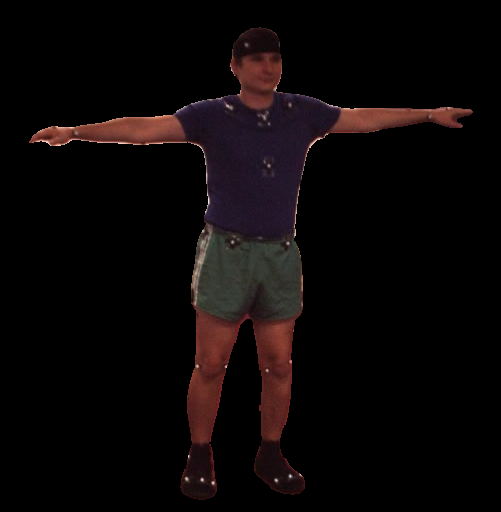

In [8]:
# single test
dataset = "h36m"

render_result_dir = f"/mnt/local4T/pengfei/projects/PointHuman/PointHuman-MPS-NeRF/logs/thuman2/test_vis_{dataset}"

img_paths = sorted(glob(os.path.join(render_result_dir, "*/*/[0-9]*.png")))

img_path = img_paths[0]

split_path = os.path.dirname(img_path).rsplit('/')
img_name = os.path.basename(img_path).split('.')[0]
input_view_name = split_path[-1]
subject_name = split_path[-2]
input_views = input_view_name.split('_')
print(input_view_name, subject_name, img_name)

calib_path = os.path.join( "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/h36m",\
    'h36m_4views', subject_name, 'calib', f'{img_name}.txt')
smplx_path = os.path.join( "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/h36m",\
    'smplx', f'{subject_name}.pkl')


mask_at_box = get_mask_box(calib_path, smplx_path)
mask_at_box.shape
x, y, w, h = cv2.boundingRect(mask_at_box.astype(np.uint8))

a = Image.open(img_path)
cat_img = np.array(a).astype(np.float32)
cat_img /= 255.0
img_gt = (cat_img[:, :512, :3])
img_pred = (cat_img[:, 512:, :3])

Image.fromarray((img_gt[y:y+h, x:x+w]*255.0).astype(np.uint8))

In [3]:
# dataset = "zjumocap"
dataset = "thuman2"
# dataset = "h36m"

render_result_dir = f"/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/results/transhuman/{dataset}"
print(render_result_dir)
img_paths = sorted(glob(os.path.join(render_result_dir, "*/*/[0-9]*.png")))
from tqdm import tqdm
skip_input_view = True
score = [] 
mask_at_box_dict = {} 
for img_path in tqdm(img_paths[:]):
    split_path = os.path.dirname(img_path).rsplit('/')
    img_name = os.path.basename(img_path).split('.')[0]
    input_view_name = split_path[-1]
    subject_name = split_path[-2]
    input_views = input_view_name.split('_')

    # print(input_view_name, subject_name, img_name, input_views)

    if skip_input_view:
        if img_name in input_views:
            continue

    a = Image.open(img_path)
    cat_img = np.array(a).astype(np.float32)
    cat_img /= 255.0
    img_gt = (cat_img[:, :512, :3])
    img_pred = (cat_img[:, 512:, :3])

    if dataset == "zjumocap":
        calib_path = os.path.join( "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/zju_mocap",\
            'zju_mocap_9views', subject_name, 'calib', f'{img_name}.txt')
        smplx_path = os.path.join( "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/zju_mocap",\
            'smplx', f'{subject_name}.pkl')

    elif dataset == "h36m":
        calib_path = os.path.join( "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/h36m",\
            'h36m_4views', subject_name, 'calib', f'{img_name}.txt')
        smplx_path = os.path.join( "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/h36m",\
            'smplx', f'{subject_name}.pkl')

    elif dataset == "thuman2":
        calib_path = os.path.join( "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/thuman2",\
            'thuman2_perspective_nolight_36views', subject_name, 'calib', f'{img_name}.txt')
        smplx_path = os.path.join( "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/thuman2",\
            'smplx', f'{subject_name}.pkl')

    mask_at_box = mask_at_box_dict.get(calib_path, None)
    if(mask_at_box is None):
        # print("not hit")
        mask_at_box = get_mask_box(calib_path, smplx_path)
        mask_at_box_dict[calib_path] = mask_at_box

    x, y, w, h = cv2.boundingRect(mask_at_box.astype(np.uint8))
    img_gt = img_gt[y:y+h, x:x+w]
    img_pred = img_pred[y:y+h, x:x+w]
    ssim = structural_similarity(img_gt, img_pred, multichannel=True)
    psnr = psnr_metric(img_gt, img_pred)
    # lpips_alex = get_lpips(loss_fn_alex, img_gt, img_pred)
    lpips_vgg = get_lpips(loss_fn_vgg, img_gt, img_pred)
    tmp = {
        'view_name': input_view_name,
        'subject_name': subject_name,
        'img_name': img_name,
        'ssim': np.array(ssim),
        'psnr': np.array(psnr),
        'lpips_vgg': lpips_vgg.squeeze().detach().numpy(),
        # 'lpips_alex': lpips_alex.squeeze().detach().numpy(),
    }
    score.append(tmp)

mask_at_box_dict_path = f"/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/results/mask_at_box_dict_{dataset}.npy"

np.save(mask_at_box_dict_path, mask_at_box_dict, allow_pickle=True)
npy_output_path = os.path.join(render_result_dir, 'render_metrics_nhp_box.npy')

np.save(npy_output_path, score, allow_pickle=True)
import pandas as pd

df = pd.DataFrame(score)
df[[ 'psnr','ssim', 'lpips_alex', 'lpips_vgg']].mean()

/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/results/transhuman/thuman2


100%|██████████| 11232/11232 [2:07:17<00:00,  1.47it/s] 


psnr          26.508074
ssim           0.935816
lpips_alex     0.102775
lpips_vgg      0.102932
dtype: object

In [58]:
import os 
from glob import glob
from tqdm import tqdm
data_path= "/mnt/local4T/pengfei/projects/PointHuman/Neural_Human_Performer/data/result/if_nerf/demo/epoch_-1/debug"
img_paths = sorted(glob(os.path.join(data_path, '*/gt/*.png')))
from PIL import Image

score = [] 
for img_path in tqdm(img_paths[:]):
    img_name = os.path.basename(img_path)
    split_path = img_path.rsplit('/', 2)
    pred_path = os.path.join(split_path[0], 'pred', img_name.replace('_gt', ''))
    img_gt = np.array(Image.open(img_path)).astype(np.float32) / 255.0
    img_pred = np.array(Image.open(pred_path)).astype(np.float32) / 255.0
    
    ssim = structural_similarity(img_gt, img_pred, multichannel=True)
    psnr = psnr_metric(img_gt, img_pred)
    lpips_alex = get_lpips(loss_fn_alex, img_gt, img_pred)
    lpips_vgg = get_lpips(loss_fn_vgg, img_gt, img_pred)
    tmp = {
        'view_name': input_view_name,
        'subject_name': subject_name,
        'img_name': img_name,
        'ssim': np.array(ssim),
        'psnr': np.array(psnr),
        'lpips_vgg': lpips_vgg.squeeze().detach().numpy(),
        'lpips_alex': lpips_alex.squeeze().detach().numpy(),
    }
    score.append(tmp)

import pandas as pd

df = pd.DataFrame(score)
df[[ 'psnr','ssim', 'lpips_alex', 'lpips_vgg']].mean()


100%|██████████| 1236/1236 [04:08<00:00,  4.98it/s]


psnr          24.994724
ssim           0.892958
lpips_alex     0.194064
lpips_vgg       0.17058
dtype: object

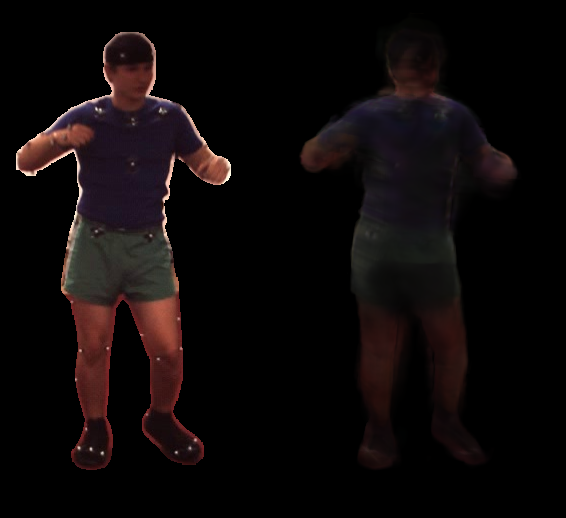

In [57]:
Image.fromarray((np.concatenate([img_gt, img_pred], axis=1)*255.0).astype(np.uint8))

In [18]:
import numpy as np
npy_path = "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/mask_at_box_dict.npy"
np.save(npy_path, mask_at_box_dict, allow_pickle=True)
mask_at_box_dict